### Model 1

In [14]:

compute_metrics(model_1, X_train, latent_dim, n_samples=1000, n_classes=5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 698ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 695ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step
Inception Score: 1.0000 ± 0.0000
Frechet Inception Distance: 177471084031952116209538448752640.0000


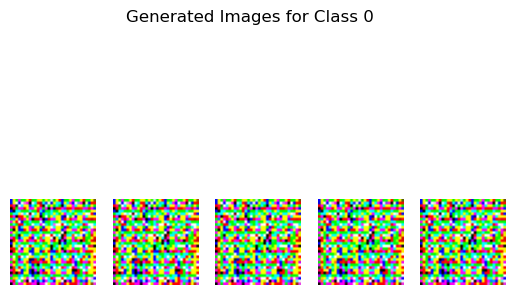

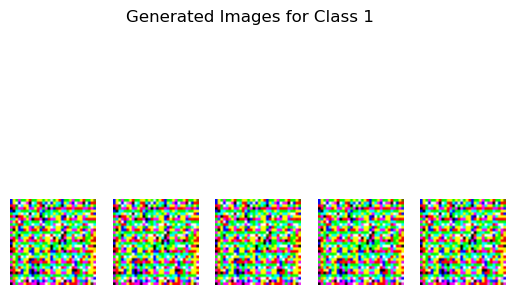

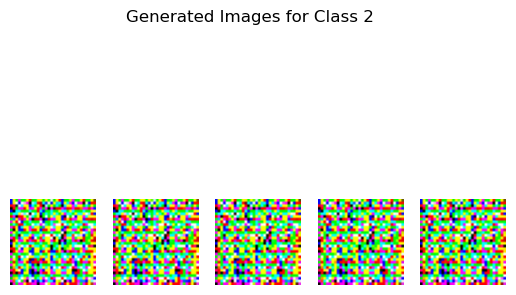

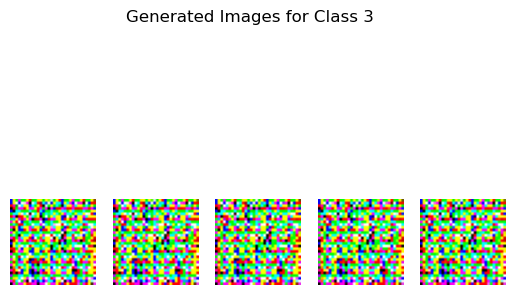

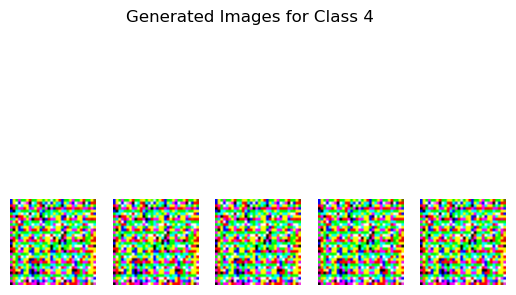

In [20]:
generate_and_save_images(generator_model, latent_dim, num_classes, n_samples=5)

### Model 2

In [17]:
compute_metrics(model_2, X_train, latent_dim, n_samples=1000, n_classes=5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 664ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 659ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 596ms/step
Inception Score: 1.0004 ± 0.0000
Frechet Inception Distance: 2193835808905450051548576285071782563150823424.0000


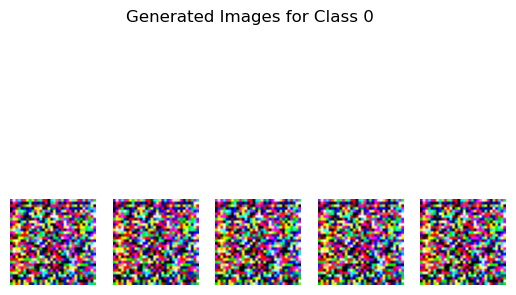

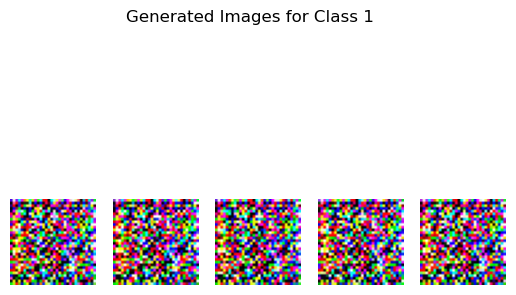

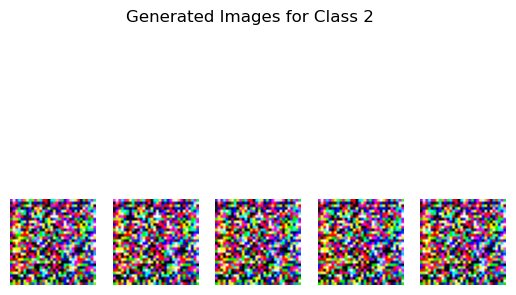

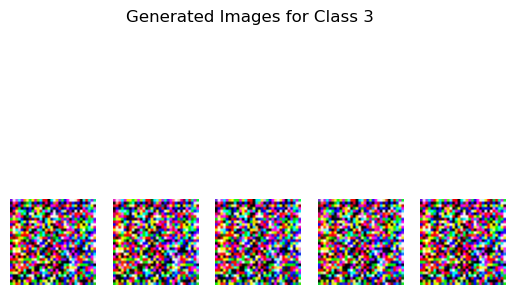

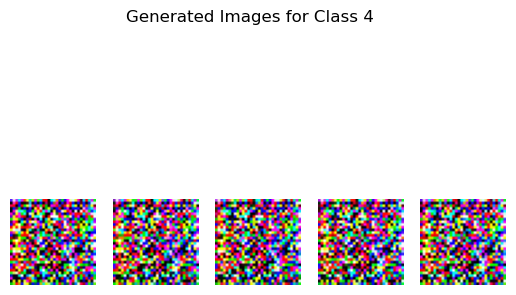

In [18]:
generate_and_save_images(generator_model, latent_dim, num_classes, n_samples=5)

# MECE
|Name | Task |
|-----|------|
|Palash Lalani | Preprocessing, Base-model building building generator, discriminator and Cgans |
|Govind | Model tuning 2 iteration and generating image function|

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
photos_df = pd.read_json('photos.json', lines=True)

In [3]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [4]:
photos_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [5]:
count_type = []
for i in photos_df['label'].unique():
    count_type.append(photos_df['label'].tolist().count(i))
    print(f"{i} class - {photos_df['label'].tolist().count(i)} images")

inside class - 56031 images
outside class - 18569 images
drink class - 15670 images
food class - 108152 images
menu class - 1678 images


<BarContainer object of 5 artists>

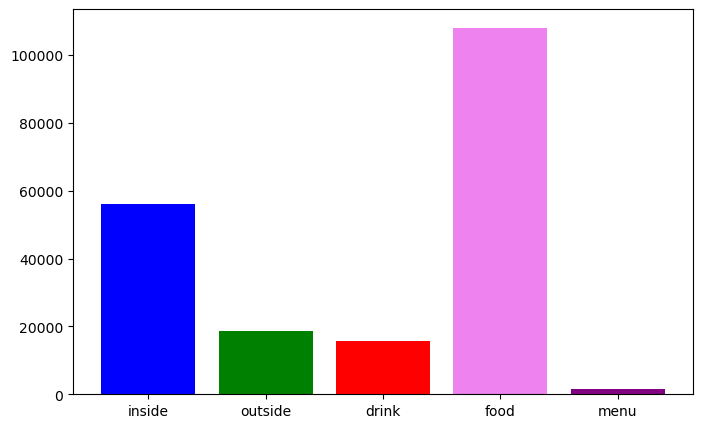

In [6]:
plt.figure(figsize=(8, 5))
plt.bar(photos_df['label'].unique(), count_type, color=['blue', 'green', 'red', 'violet', 'purple'])

In [7]:
# Separate the "menu" class
menu_df = photos_df[photos_df['label'] == 'menu']

# List to store undersampled DataFrames
undersampled_dfs = []

# For all other classes, we will undersample to 7000 items
for label in photos_df['label'].unique():
    if label != 'menu':  # Skip the "menu" class
        classes_df = photos_df[photos_df['label'] == label]
        
        # If the class has more than 1678 items, undersample
        if len(classes_df) > 1678:  
            undersampled_class = classes_df.sample(n=7000, random_state=42)  # Randomly sample 4000 items
        else:
            undersampled_class = classes_df  # If the class has 7000 or fewer, keep all items
            
        undersampled_dfs.append(undersampled_class)  # Append the undersampled class DataFrame to the list

# Combine all undersampled DataFrames with the "menu" class
image_undersampled = pd.concat([menu_df] + undersampled_dfs, ignore_index=True)

# Check the count of each class after undersampling
print(image_undersampled['label'].value_counts())

label
inside     7000
outside    7000
drink      7000
food       7000
menu       1678
Name: count, dtype: int64


In [8]:
image_undersampled

,photo_id,business_id,caption,label
0,6LJa8QZOGBjt9maE5miLhw,368cyArdo0P0aDUOhhE4PA,Drive-thru menu,menu
1,DtsfhqhqUB-tjs5XbwJfXw,s-74t4aQKL2pWeQmIB-c1Q,Vegan Options,menu
2,VB75GlozO9ZzkhQC8mY6Ag,I-Kn6FzE4wqX4CF3dUa7cw,Currently providing takeout - so take advantag...,menu
3,9n5RobGsibyp8IriSszsSQ,htx6Uime2SkiE-zC7hxb-g,,menu
4,cklpUVFnNF4WxE4yMCRyZw,swVdc9piXvG0AXwL-F0GfQ,Happy hour menu,menu
...,...,...,...,...
29673,gb2_nIecBghZEi0b7PbIaQ,-FM4CxOg4XXmX_Ebky_SiQ,Dessert time!!,food
29674,qHGPA5rxYsrB0JED4Of9nw,cELLyBogNeU_QbN5tJsBRA,,food
29675,lp2Kav3-V01XpkUDNB89rg,baF2ZFEtsIo2A1k61x3QSw,,food
29676,NbBtSevPEf-3mg-hKhmtvw,u40qery_d1rwMwOprqCfKw,Hamburger with Fries,food


In [9]:
image_7000 = image_undersampled.drop(columns=['business_id','caption'] ,axis=1)

In [10]:
image_7000

,photo_id,label
0,6LJa8QZOGBjt9maE5miLhw,menu
1,DtsfhqhqUB-tjs5XbwJfXw,menu
2,VB75GlozO9ZzkhQC8mY6Ag,menu
3,9n5RobGsibyp8IriSszsSQ,menu
4,cklpUVFnNF4WxE4yMCRyZw,menu
...,...,...
29673,gb2_nIecBghZEi0b7PbIaQ,food
29674,qHGPA5rxYsrB0JED4Of9nw,food
29675,lp2Kav3-V01XpkUDNB89rg,food
29676,NbBtSevPEf-3mg-hKhmtvw,food


In [11]:
import os
import shutil
import json
from tensorflow.keras.utils import load_img, img_to_array
from PIL import UnidentifiedImageError
import numpy as np

def load_images(data, image_folder, output_folder, labels_json_path):
    """
    Load images from a dataset, resizing and normalizing them, while limiting the number 
    of images per class to avoid class imbalance. The selected images are saved to a 
    specified output folder, and their labels are saved in JSON format.

    Input:
    data : pd.DataFrame
        DataFrame containing the image information such as 'photo_id' and 'label'.
    image_folder : str
        The path to the folder where the images are stored.
    output_folder : str
        The path to the folder where selected images will be stored.
    labels_json_path : str
        The path to save the labels JSON file.

    Return:
    images : np.ndarray
        Numpy array containing the preprocessed images.
    labels : np.ndarray
        Numpy array containing the corresponding labels for the images.
    """
    
    images, labels = [], []  # Lists to store images and their labels
    json_labels = {}         # Dictionary to store labels for JSON

    # Keep track of the count of images loaded for each label
    label_data_count = {
        "inside": 0,
        "outside": 0,
        "drink": 0,
        "food": 0,
        "menu": 0
    }

    max_image_count = 7000  # Maximum number of images per class to maintain balance
    height = width = 32     # Size of the image (e.g., 32x32)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        
        # Stop if the maximum image count for all labels is reached
        if all(value == max_image_count for value in label_data_count.values()):
            break
        
        try:
            photo_id = row['photo_id']  # Get the photo ID
            label = row['label']       # Get the corresponding label
            
            # Check if the current label still needs more images
            label_count = label_data_count.get(label)
            if label_count < max_image_count:
                
                # Build the path to the image file
                image_path = os.path.join(image_folder, f"{photo_id}.jpg")
                
                # Load and preprocess the image (resize and normalize)
                image = load_img(image_path, target_size=(height, width))  # Resizing the image
                image = img_to_array(image) / 255.0  # Normalize to range [0, 1]
                image = (image - 0.5) * 2           # Normalize to [-1, 1]
                
                # Append the preprocessed image and its label
                images.append(image)
                labels.append(label)
                
                # Save the image to the output folder
                output_path = os.path.join(output_folder, f"{photo_id}.jpg")
                shutil.copy(image_path, output_path)  # Copy the image to the output folder
                
                # Add to JSON dictionary
                json_labels[photo_id] = label

                # Update the count for the current label
                label_data_count[label] += 1

        except UnidentifiedImageError:
            # Handle cases where the file is not a valid image
            print(f"Skipping file {row['photo_id']}, not an image.")
        except FileNotFoundError:
            # Handle cases where the image file doesn't exist
            print(f"File not found: {row['photo_id']}")
    
    # Save labels to JSON file
    with open(labels_json_path, 'w') as json_file:
        json.dump(json_labels, json_file, indent=4)

    # Convert lists to numpy arrays and return
    return np.array(images), np.array(labels)

# Example usage
image_folder = r'D:\term 3\deep learning\graded 4\photos'
output_folder = r'D:\term 3\deep learning\graded 4\Selected_Photos'
labels_json_path = r'D:\term 3\deep learning\graded 4\labels.json'

X, y = load_images(image_7000, image_folder, output_folder, labels_json_path)


Skipping file l_rMdwgrvjm2PyHyXBcBTw, not an image.
Skipping file 1wd_eyhMrTqUmicDmn4_Kw, not an image.
Skipping file kjMBhxBXOUE7SSUQb-YQbw, not an image.
Skipping file RhC7TNmFvbR9GWrlrl5dsA, not an image.
Skipping file tSHz7RzlgceAItRejZ396A, not an image.
Skipping file QhATx1B1n8uf8C6siMNTfA, not an image.
Skipping file OK6HsALzFcBAUlrroKHZGg, not an image.
Skipping file ARwqGQZaT0p-XpYYjMXgQg, not an image.
Skipping file 43fHlHSYQ_79OBJW1aVUxA, not an image.
Skipping file AMSyCOP3-Eb_ivNA8w1Vhw, not an image.
Skipping file 9BvYOtforBBP6MvvDogtmw, not an image.
Skipping file NfayhoTudVJQsEF-XlPyjw, not an image.
Skipping file 2S78q98b_VpBD7vkrDE5-A, not an image.
Skipping file ke4ohxa93GJz0KH9H2kwsQ, not an image.
Skipping file JZZ716oX6_MqH6L_MkWK-A, not an image.


In [ ]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Label encoding 
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
X_train.shape, y_train_encoded.shape

((23730, 32, 32, 3), (23730,))

### Discriminator

In [14]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, LeakyReLU, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def define_discriminator(img_shape=(32, 32, 3), n_classes=5):
    """
    Build the discriminator model for conditional GAN.

    Parameters:
    - img_shape: Shape of the input image (height, width, channels)
    - num_classes: Number of unique labels (classes)

    Returns:
    - Discriminator model
    """
    # Label input and embedding
    input_label = Input(shape=(1,))
    label_embedding = Embedding(n_classes, 10)(input_label)  # Embed label
    label_embedding = Dense(img_shape[0] * img_shape[1])(label_embedding)  # Match image resolution
    label_embedding = Reshape((img_shape[0], img_shape[1], 1))(label_embedding)  # Reshape to match image dimensions

    # Image input
    input_image = Input(shape=img_shape)

    # Merge image and label embedding
    merge = Concatenate()([input_image, label_embedding])

    # Convolutional layers
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)

    # Output layer
    output_layer = Dense(1, activation="sigmoid")(fe)  # Real or fake classification

    # Define and compile the model
    model = Model([input_image, input_label], output_layer, name="Discriminator")
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [15]:
test_discri = define_discriminator()
test_discri.summary()

c:\Users\samys\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 10)     │         50 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1024)   │     11,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 32, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32, 4) │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      4,736 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8192)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      8,193 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 171,827 (671.20 KB)

 Trainable params: 171,827 (671.20 KB)

 Non-trainable params: 0 (0.00 B)

### Generator

In [16]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, LeakyReLU, Concatenate, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Model

def define_generator(latent_dim, n_classes=5, embedding_dim=10):
    """
    Build the generator model for conditional GAN.

    Parameters:
    - latent_dim: Dimension of the latent vector
    - n_classes: Number of unique labels (classes)
    - embedding_dim: Dimensionality of label embeddings

    Returns:
    - Generator model
    """
    # Label input and embedding
    input_label = Input(shape=(1,))
    label_embedding = Embedding(n_classes, embedding_dim)(input_label)  # Embed label
    label_embedding = Dense(8 * 8)(label_embedding)  # Dense layer to match spatial dimensions
    label_embedding = Reshape((8, 8, 1))(label_embedding)  # Reshape to 8x8x1 for concatenation

    # Latent input
    in_lat = Input(shape=(latent_dim,))
    num_nodes = 128 * 8 * 8
    gen = Dense(num_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 128))(gen)

    # Merge label embedding and latent input
    merge = Concatenate()([gen, label_embedding])

    # Upsample to reach the target resolution (32x32)
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(merge)  # Upsample to 16x16
    gen = LeakyReLU(negative_slope=0.2)(gen)
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(gen)  # Upsample to 32x32
    gen = LeakyReLU(negative_slope=0.2)(gen)

    # Final output layer (32x32x3)
    output_layer = Conv2D(3, (3, 3), activation="tanh", padding="same")(gen)  # RGB output

    # Define model
    model = Model([in_lat, input_label], output_layer, name="Generator")
    return model


In [17]:
test_gen = define_generator(50, n_classes=5)
test_gen.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8192)      │    417,792 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 10)     │         50 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8192)      │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │        704 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 129) │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    264,320 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32, 3) │      3,459 │ leaky_re_lu_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 948,597 (3.62 MB)

 Trainable params: 948,597 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

### cGAN 

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def define_gan(generator, discriminator):
    """
    Build the conditional GAN model by combining the generator and discriminator.

    Parameters:
    - generator: Generator model
    - discriminator: Discriminator model

    Returns:
    - GAN model
    """
    # Freeze the discriminator weights while training the GAN
    discriminator.trainable = False

    # Inputs to the generator
    gen_noise, gen_label = generator.input  # Latent vector (noise) and label
    gen_output = generator.output  # Generated image

    # Discriminator evaluates the generated image and label
    gan_output = discriminator([gen_output, gen_label])

    # Define and compile the GAN model
    model = Model([gen_noise, gen_label], gan_output, name="Conditional_GAN")
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  # Use learning_rate instead of lr
    model.compile(loss="binary_crossentropy", optimizer=opt)  # Binary loss since it's real vs fake
    return model

In [19]:
test_gan = define_gan(test_gen, test_discri)
test_gan.summary()

Model: "Conditional_GAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8192)      │    417,792 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 10)     │         50 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8192)      │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │        704 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 129) │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    264,320 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32, 3) │      3,459 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │    171,827 │ conv2d_2[0][0],   │
│ (Functional)        │                   │            │ input_layer_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,120,424 (4.27 MB)

 Trainable params: 948,597 (3.62 MB)

 Non-trainable params: 171,827 (671.20 KB)

In [4]:
def generate_real_samples(dataset, n_samples):
	# split into image vectors and labels
	X_train, y_train_encoded = dataset  
	# choose random instances
	ix = np.random.randint(0, X_train.shape[0], n_samples)
	# select image vector and labels
	X_real, y_real_label = X_train[ix], y_train_encoded[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to Yelp labels)
	y = np.ones((n_samples, 1))  #Label=1 indicating they are real
	return [X_real, y_real_label], y

In [5]:
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # Generate random points in the latent space
    x_input = np.random.randn(n_samples * latent_dim)
    z_input = x_input.reshape(n_samples, latent_dim)  # Reshape to [n_samples, latent_dim]

    # Generate random integer labels for the latent points
    rand_labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, rand_labels]

In [6]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input], verbose=0)
	# create class labels
	y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [23]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)  # Number of batches per epoch
    half_batch = n_batch // 2  # Half batch size

    for i in range(n_epochs):  # Loop over epochs
        for j in range(bat_per_epo):  # Loop over batches
            # ---- Train Discriminator ----
            # Generate real samples
            [X_real, y_real_label], y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, d_acc_real = discriminator.train_on_batch([X_real, y_real_label], y_real)

            # Generate fake samples
            [X_fake, labels_fake], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            d_loss_fake, d_acc_fake = discriminator.train_on_batch([X_fake, labels_fake], y_fake)

            # Calculate combined discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

            # ---- Train Generator ----
            # Generate latent points
            z_input, labels_input = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))  # Real labels for generator to trick discriminator
            g_loss = gan.train_on_batch([z_input, labels_input], y_gan)

            # Ensure g_loss is scalar
            g_loss = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

            # Logging
            if (j + 1) % 55 == 0:  # Print every 55th batch
                print(f" Epoch {i+1}/{n_epochs}, Batch {j+1}/{bat_per_epo}, D_loss_: {d_loss:.4f}, G_loss: {g_loss:.4f}")
        print("--------------------------------------------------------------------------")

    # Save the generator model after training
    generator.save('cGANs.keras')


In [24]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = X_train, y_train_encoded

In [25]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5)

c:\Users\samys\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


 Epoch 1/5, Batch 55/185, D_loss_: 0.9047, G_loss: 0.9069
 Epoch 1/5, Batch 110/185, D_loss_: 1.0226, G_loss: 1.0244
 Epoch 1/5, Batch 165/185, D_loss_: 1.1335, G_loss: 1.1351
--------------------------------------------------------------------------
 Epoch 2/5, Batch 55/185, D_loss_: 1.2676, G_loss: 1.2690
 Epoch 2/5, Batch 110/185, D_loss_: 1.3512, G_loss: 1.3525
 Epoch 2/5, Batch 165/185, D_loss_: 1.4237, G_loss: 1.4249
--------------------------------------------------------------------------
 Epoch 3/5, Batch 55/185, D_loss_: 1.5086, G_loss: 1.5096
 Epoch 3/5, Batch 110/185, D_loss_: 1.5620, G_loss: 1.5629
 Epoch 3/5, Batch 165/185, D_loss_: 1.6080, G_loss: 1.6088
--------------------------------------------------------------------------
 Epoch 4/5, Batch 55/185, D_loss_: 1.6618, G_loss: 1.6625
 Epoch 4/5, Batch 110/185, D_loss_: 1.6966, G_loss: 1.6973
 Epoch 4/5, Batch 165/185, D_loss_: 1.7281, G_loss: 1.7287
-----------------------------------------------------------------------

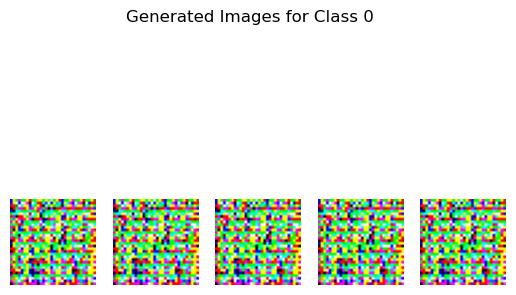

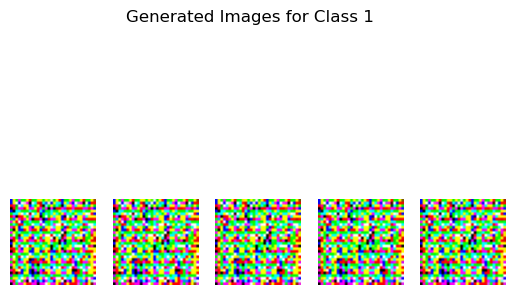

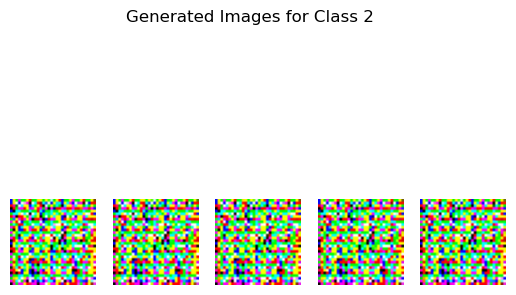

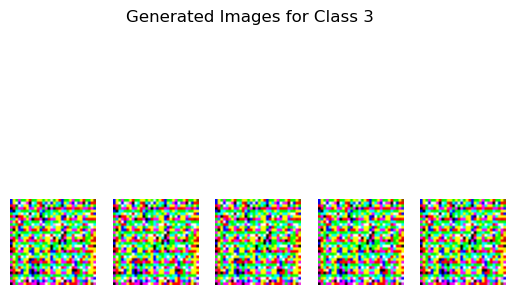

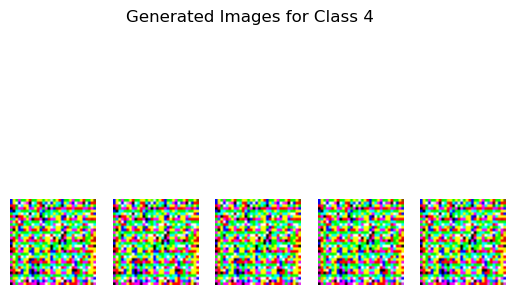

In [19]:
def generate_and_save_images(generator_model, latent_dim, num_classes, n_samples=5):
    """
    Generate and save images using the trained generator model.

    Parameters:
    - generator_model: Trained generator model
    - latent_dim: Dimension of the latent space
    - num_classes: Number of classes
    - n_samples: Number of images per class to generate
    """
    # For each class, generate images
    for class_label in range(num_classes):
        # Generate latent points and specific class labels
        z_input, labels = generate_latent_points(latent_dim, n_samples, num_classes)
        labels = np.full((n_samples,), class_label)  # Set all labels to the current class

        # Generate images
        generated_images = generator_model.predict([z_input, labels], verbose=0)

        # Rescale images to [0, 1] for visualization
        generated_images = (generated_images + 1) / 2.0

        # Plot the generated images
        for i in range(n_samples):
            plt.subplot(1, n_samples, i + 1)
            plt.axis('off')
            plt.imshow(generated_images[i])

        plt.suptitle(f"Generated Images for Class {class_label}")
        plt.show()


# Load the trained generator model
generator_model = load_model('cGANs.keras')

# Define parameters
latent_dim = 100  # Replace with your latent dimension
num_classes = 5   # Replace with the number of classes in your dataset

# Generate and display images
generate_and_save_images(generator_model, latent_dim, num_classes, n_samples=5)

## IS and FID metrics

In [7]:
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model

# Load the InceptionV3 model for feature extraction
def load_inception_model():
    model = InceptionV3(include_top=True, weights='imagenet')
    feature_model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
    return model, feature_model

# Compute Inception Score (IS)
def calculate_inception_score(images, inception_model, num_splits=10):
    images = preprocess_input(images)  # Normalize images for InceptionV3
    preds = inception_model.predict(images)  # Get class probabilities
    split_scores = []

    # Split images into splits and compute scores
    for i in range(num_splits):
        part = preds[i * (len(images) // num_splits): (i + 1) * (len(images) // num_splits)]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), axis=0)))
        kl_mean = np.mean(np.sum(kl, axis=1))
        split_scores.append(np.exp(kl_mean))  # Exponentiate the KL divergence

    return np.mean(split_scores), np.std(split_scores)

# Compute Frechet Inception Distance (FID)
def calculate_fid(real_features, generated_features):
    # Calculate means and covariances
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    # Numerical issues may make covmean complex; take only the real part
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [8]:
def resize_images_one_by_one(images, target_size=(299, 299)):
    """
    Resize images one at a time to avoid memory issues.
    """
    resized_images = []
    for img in images:
        resized_img = tf.image.resize(img, target_size)
        resized_images.append(resized_img)
    return tf.stack(resized_images)  # Stack back into a single tensor


def compute_metrics(generator, X_train, latent_dim, n_samples=1000, n_classes=5):
    """
    Compute Inception Score (IS) and Frechet Inception Distance (FID) for a trained cGAN.
    """
    # Load Inception model
    inception_model, feature_model = load_inception_model()

    # Generate fake images
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes)
    generated_images = generator.predict([z_input, labels_input])
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    # Resize generated images one by one
    generated_images_resized = resize_images_one_by_one(generated_images, target_size=(299, 299))

    # Select real images randomly from X_train
    ix = np.random.randint(0, X_train.shape[0], n_samples)
    real_images = X_train[ix]
    real_images = (real_images + 1) / 2.0  # Rescale to [0, 1]

    # Resize real images one by one
    real_images_resized = resize_images_one_by_one(real_images, target_size=(299, 299))

    # Compute Inception Score (IS) on resized generated images
    is_mean, is_std = calculate_inception_score(generated_images_resized, inception_model)

    # Compute FID
    # Extract features for real and fake images
    real_features = feature_model.predict(preprocess_input(real_images_resized))
    fake_features = feature_model.predict(preprocess_input(generated_images_resized))
    fid = calculate_fid(real_features, fake_features)

    # Print metrics
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    print(f"Frechet Inception Distance: {fid:.4f}")



In [12]:
from keras.models import load_model
import tensorflow as tf
model_1 = load_model('cGANs.keras')

In [13]:
latent_dim = 100 
compute_metrics(model_1, X_train, latent_dim, n_samples=1000, n_classes=5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 641ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 649ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 593ms/step
Inception Score: 1.0000 ± 0.0000
Frechet Inception Distance: 4624389389632580856659973293211648.0000


**Only Noise is being generated as training progresses both generator and discriminator loss keeps on increasing which needs to be addressed**

## Model-2 With Improvement

1. **Regularization in Discriminator**: dropout layer to reduce over-learning of discriminator
2. **BatchNormalization in Generator**: Helps stabilize the generator updates
3. **Label Smoothing**: Prevents Discriminator to be overconfident

### Discriminator-2

In [3]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, LeakyReLU, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def train_discriminator(img_shape=(32, 32, 3), n_classes=5):
    """
    Improved Discriminator for cGAN.
    """
    # Label input and embedding
    input_label = Input(shape=(1,))
    label_embedding = Embedding(n_classes, 10)(input_label)
    label_embedding = Dense(img_shape[0] * img_shape[1])(label_embedding)
    label_embedding = Reshape((img_shape[0], img_shape[1], 1))(label_embedding)

    # Image input
    input_image = Input(shape=img_shape)

    # Merge image and label embedding
    merge = Concatenate()([input_image, label_embedding])

    # Convolutional layers with more filters
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.3)(fe)
    

    # Output layer
    output_layer = Dense(1, activation="sigmoid")(fe)

    # Define and compile the model
    model = Model([input_image, input_label], output_layer, name="Discriminator")
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


In [4]:
test_dis = train_discriminator()
test_dis.summary()

c:\Users\samys\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 10)     │         50 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1024)   │     11,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 32, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32, 4) │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      4,736 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 128) │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8192)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      8,193 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 171,827 (671.20 KB)

 Trainable params: 171,827 (671.20 KB)

 Non-trainable params: 0 (0.00 B)

## Generator-2

In [4]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def train_generator(latent_dim, n_classes=5):
    """
    Improved Generator for cGAN.
    """
    # Label input and embedding
    input_label = Input(shape=(1,))
    label_embedding = Embedding(n_classes, 10)(input_label)
    label_embedding = Dense(8 * 8)(label_embedding)
    label_embedding = Reshape((8, 8, 1))(label_embedding)

    # Latent input
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256 * 8 * 8)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 256))(gen)

    # Merge latent input and label embedding
    merge = Concatenate()([gen, label_embedding])

    # Upsampling layers
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Output layer
    output_layer = Conv2DTranspose(3, (7, 7), activation="tanh", padding="same")(gen)

    # Define model
    model = Model([in_lat, input_label], output_layer, name="Generator")
    return model


In [6]:
test_gen = train_generator(50, n_classes=5)
test_gen.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16384)     │    835,584 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 10)     │         50 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16384)     │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │        704 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 256) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 257) │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    526,464 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    131,136 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32, 3) │      9,411 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,504,117 (5.74 MB)

 Trainable params: 1,503,733 (5.74 MB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
def train_gan(generator, discriminator):
    """
    Improved cGAN model combining generator and discriminator.
    """
    discriminator.trainable = False  # Freeze discriminator

    # Inputs for generator
    gen_noise, gen_label = generator.input
    gen_output = generator.output

    # Connect generator output to discriminator input
    gan_output = discriminator([gen_output, gen_label])

    # Define and compile the cGAN model
    model = Model([gen_noise, gen_label], gan_output, name="Conditional_GAN")
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model


In [8]:
test_gan = train_gan(test_gen, test_dis)
test_gan.summary()

Model: "Conditional_GAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16384)     │    835,584 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 10)     │         50 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16384)     │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │        704 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 256) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 257) │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    526,464 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    131,136 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32, 3) │      9,411 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │    171,827 │ conv2d_transpose… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,675,944 (6.39 MB)

 Trainable params: 1,503,733 (5.74 MB)

 Non-trainable params: 172,211 (672.70 KB)

In [6]:
def real_samples(dataset, n_samples):
	# split into images and labels
	X_train, y_train_encoded = dataset  
	# choose random instances
	ix = np.random.randint(0, X_train.shape[0], n_samples)
	# select images and labels
	X_real, y_real_label = X_train[ix], y_train_encoded[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to Yelp labels)
	y = np.random.uniform(0.8, 1.0, (n_samples, 1))  #Label=1 indicating they are real (Adding Smoothning)
	return [X_real, y_real_label], y

In [7]:
def latent_points(latent_dim, n_samples, n_classes=5):
    # Generate random points in the latent space
    z_input = np.random.normal(0, 1, (n_samples, latent_dim))  # Reshape to [n_samples, latent_dim]

    # Generate random integer labels for the latent points
    rand_labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, rand_labels]

In [12]:
def fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input], verbose=0)
	# create class labels
	y = np.random.uniform(0.0, 0.2,(n_samples, 1)) #Label=0 indicating they are fake (Adding Smoothning)
	return [images, labels_input], y

In [13]:
def train_1(generator, discriminator, gan, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)  # Number of batches per epoch
    half_batch = n_batch // 2  # Half batch size

    for i in range(n_epochs):  # Loop over epochs
        for j in range(bat_per_epo):  # Loop over batches
            # ---- Train Discriminator ----
            # Generate real samples
            [X_real, y_real_label], y_real = real_samples(dataset, half_batch)
            d_loss_real, d_acc_real = discriminator.train_on_batch([X_real, y_real_label], y_real)

            # Generate fake samples
            [X_fake, labels_fake], y_fake = fake_samples(generator, latent_dim, half_batch)
            d_loss_fake, d_acc_fake = discriminator.train_on_batch([X_fake, labels_fake], y_fake)

            d_loss = (d_loss_real + d_loss_fake)/2

            # ---- Train Generator ----
            [z_input, labels_input] = latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))  # Real labels for generator to trick discriminator
            g_loss = gan.train_on_batch([z_input, labels_input], y_gan)

            # Print progress
            #print('%d/%d, %d/%d, d1_real=%.3f, d2_fake=%.3f, g=%.3f' %
            #      (i + 1, n_epochs, j + 1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
            # Print progress after each epoch
            if (j + 1) % 92 == 0:  # Print every 110th batch
                print(f" Epoch {i+1}/{n_epochs}, Batch {j+1}/{bat_per_epo}, D_loss_: {d_loss:.4f}, G_loss: {g_loss[1]:.4f} ")
        print("--------------------------------------------------------------------------")

    # Save the generator model after training
    generator.save('cGANs_1.keras')

In [14]:
# size of the latent space
latent_dim = 100
# create the discriminator
dis_model = train_discriminator()
# create the generator
gen_model = train_generator(latent_dim)
# create the gan
cgan_model = train_gan(gen_model, dis_model)
# load image data
dataset = X_train, y_train_encoded

In [15]:
# train model
train_1(gen_model, dis_model, cgan_model, dataset, latent_dim, n_epochs=5)

c:\Users\samys\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


 Epoch 1/5, Batch 92/185, D_loss_: 0.6992, G_loss: 0.6993 
 Epoch 1/5, Batch 184/185, D_loss_: 0.7237, G_loss: 0.7240 
--------------------------------------------------------------------------
 Epoch 2/5, Batch 92/185, D_loss_: 0.7841, G_loss: 0.7846 
 Epoch 2/5, Batch 184/185, D_loss_: 0.8995, G_loss: 0.9004 
--------------------------------------------------------------------------
 Epoch 3/5, Batch 92/185, D_loss_: 1.0633, G_loss: 1.0644 
 Epoch 3/5, Batch 184/185, D_loss_: 1.2332, G_loss: 1.2344 
--------------------------------------------------------------------------
 Epoch 4/5, Batch 92/185, D_loss_: 1.3873, G_loss: 1.3883 
 Epoch 4/5, Batch 184/185, D_loss_: 1.5154, G_loss: 1.5163 
--------------------------------------------------------------------------
 Epoch 5/5, Batch 92/185, D_loss_: 1.6239, G_loss: 1.6247 
 Epoch 5/5, Batch 184/185, D_loss_: 1.7149, G_loss: 1.7157 
--------------------------------------------------------------------------


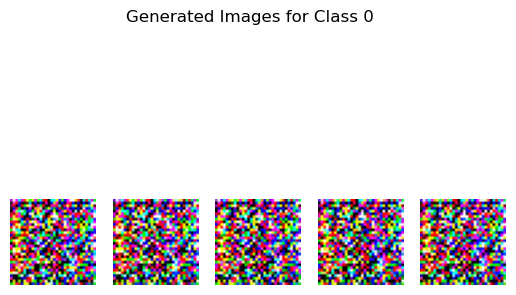

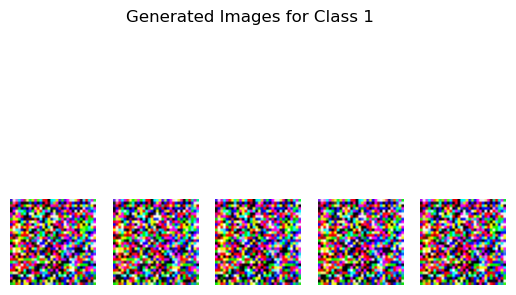

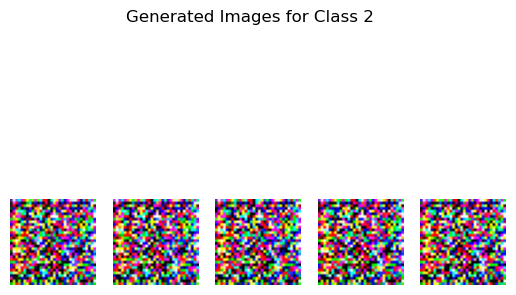

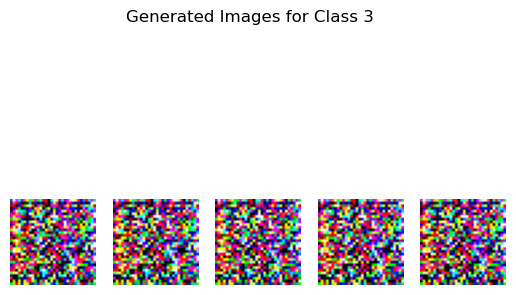

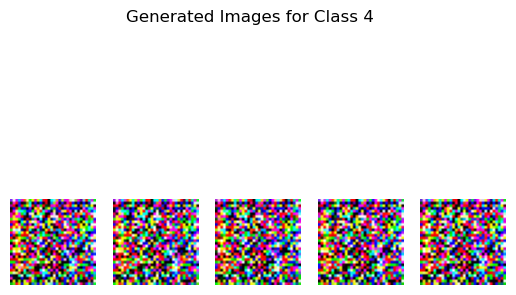

In [17]:
from keras.models import load_model
def generate_and_save_images(generator_model, latent_dim, num_classes, n_samples=5):
    """
    Generate and save images using the trained generator model.

    Parameters:
    - generator_model: Trained generator model
    - latent_dim: Dimension of the latent space
    - num_classes: Number of classes
    - n_samples: Number of images per class to generate
    """
    # For each class, generate images
    for class_label in range(num_classes):
        # Generate latent points and specific class labels
        z_input, labels = generate_latent_points(latent_dim, n_samples, num_classes)
        labels = np.full((n_samples,), class_label)  # Set all labels to the current class

        # Generate images
        generated_images = generator_model.predict([z_input, labels], verbose=0)

        # Rescale images to [0, 1] for visualization
        generated_images = (generated_images + 1) / 2.0

        # Plot the generated images
        for i in range(n_samples):
            plt.subplot(1, n_samples, i + 1)
            plt.axis('off')
            plt.imshow(generated_images[i])

        plt.suptitle(f"Generated Images for Class {class_label}")
        plt.show()


# Load the trained generator model
generator_model = load_model('cGANs_1.keras')

# Define parameters
latent_dim = 100  # Replace with your latent dimension
num_classes = 5   # Replace with the number of classes in your dataset

# Generate and display images
generate_and_save_images(generator_model, latent_dim, num_classes, n_samples=5)

In [15]:
model_2 = load_model('cGANs_1.keras')

In [16]:

compute_metrics(model_2, X_train, latent_dim, n_samples=1000, n_classes=5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 650ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 662ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step
Inception Score: 1.0004 ± 0.0000
Frechet Inception Distance: 32182406358183666025525287570156492855993521565855645696.0000


### The generator is still generating noise. Need to address the issues.